In [1]:
from model import CIFAR10CNN2, CIFAR10CNN3
from utils import Cifar10Dataset
from train import Trainer

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
%matplotlib inline


import albumentations as A
from albumentations.pytorch import ToTensorV2

#### Train Transforms using Albumentations

In [2]:
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                        fill_value=0.4734),
        A.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2470, 0.2435, 0.2616),
            p =1.0
        ),
        ToTensorV2()
    ],
    p=1.0
)

#### Test Transforms using Albumentations

In [3]:
test_transforms = A.Compose(
    [
        A.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2470, 0.2435, 0.2616),
            p =1.0
        ),
        ToTensorV2()
    ],
    p=1.0
)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
        
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

CUDA Available? True


In [5]:
trainset = Cifar10Dataset(root='./data', train=True,
                                        download=True, transform=train_transforms)

                                        

trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

Files already downloaded and verified


In [6]:
testset = Cifar10Dataset(root='./data', train=False,
                                        download=True, transform=test_transforms)

testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


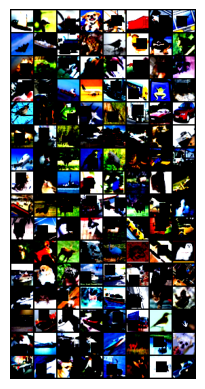

In [7]:
images, _ = next(iter(trainloader))
# images = images.numpy()

grid = torchvision.utils.make_grid(images)
grid = grid.numpy().transpose((1,2,0))

plt.imshow(grid)
plt.axis('off')
plt.show()

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [9]:
model1 = CIFAR10CNN2(num_classes=10).to(device)

In [10]:
model1_trainer = Trainer(model1)

In [11]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CIFAR10CNN2().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 28, 28]             640
            Conv2d-5           [-1, 64, 28, 28]           4,160
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]             640
            Conv2d-9           [-1, 64, 28, 28]           4,160
      BatchNorm2d-10           [-1, 64, 28, 28]             128
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]             640
           Conv2d-13           [-1, 64, 28, 28]           4,160
      BatchNorm2d-14           [-1

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [13]:
from torch.optim.lr_scheduler import StepLR, LambdaLR

model =  CIFAR10CNN2().to(device)
optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 80
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

EPOCH: 0


Loss=1.2131768465042114 Batch_id=390 Accuracy=44.00: 100%|███████████████████████████| 391/391 [00:21<00:00, 17.82it/s]



Test set: Average loss: 0.0092, Accuracy: 5830/10000 (58.30%)

EPOCH: 1


Loss=1.0241467952728271 Batch_id=390 Accuracy=56.01: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.32it/s]



Test set: Average loss: 0.0085, Accuracy: 6239/10000 (62.39%)

EPOCH: 2


Loss=1.2819758653640747 Batch_id=390 Accuracy=60.39: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.36it/s]



Test set: Average loss: 0.0066, Accuracy: 7060/10000 (70.60%)

EPOCH: 3


Loss=0.9770833253860474 Batch_id=390 Accuracy=63.08: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.35it/s]



Test set: Average loss: 0.0064, Accuracy: 7166/10000 (71.66%)

EPOCH: 4


Loss=0.961380660533905 Batch_id=390 Accuracy=64.86: 100%|████████████████████████████| 391/391 [00:21<00:00, 18.20it/s]



Test set: Average loss: 0.0064, Accuracy: 7187/10000 (71.87%)

EPOCH: 5


Loss=0.9790714383125305 Batch_id=390 Accuracy=66.23: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.35it/s]



Test set: Average loss: 0.0056, Accuracy: 7496/10000 (74.96%)

EPOCH: 6


Loss=0.9877887964248657 Batch_id=390 Accuracy=67.41: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.43it/s]



Test set: Average loss: 0.0053, Accuracy: 7658/10000 (76.58%)

EPOCH: 7


Loss=1.1988108158111572 Batch_id=390 Accuracy=68.52: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.49it/s]



Test set: Average loss: 0.0052, Accuracy: 7708/10000 (77.08%)

EPOCH: 8


Loss=0.8874461054801941 Batch_id=390 Accuracy=69.33: 100%|███████████████████████████| 391/391 [00:22<00:00, 17.48it/s]



Test set: Average loss: 0.0054, Accuracy: 7639/10000 (76.39%)

EPOCH: 9


Loss=0.7791467308998108 Batch_id=390 Accuracy=69.70: 100%|███████████████████████████| 391/391 [00:23<00:00, 16.46it/s]



Test set: Average loss: 0.0053, Accuracy: 7703/10000 (77.03%)

EPOCH: 10


Loss=0.7416605949401855 Batch_id=390 Accuracy=70.51: 100%|███████████████████████████| 391/391 [00:23<00:00, 16.71it/s]



Test set: Average loss: 0.0048, Accuracy: 7904/10000 (79.04%)

EPOCH: 11


Loss=0.5856478214263916 Batch_id=390 Accuracy=71.16: 100%|███████████████████████████| 391/391 [00:23<00:00, 16.63it/s]



Test set: Average loss: 0.0050, Accuracy: 7846/10000 (78.46%)

EPOCH: 12


Loss=0.6526035070419312 Batch_id=390 Accuracy=71.73: 100%|███████████████████████████| 391/391 [00:23<00:00, 16.94it/s]



Test set: Average loss: 0.0049, Accuracy: 7859/10000 (78.59%)

EPOCH: 13


Loss=0.8872997164726257 Batch_id=390 Accuracy=72.40: 100%|███████████████████████████| 391/391 [00:23<00:00, 16.66it/s]



Test set: Average loss: 0.0049, Accuracy: 7859/10000 (78.59%)

EPOCH: 14


Loss=0.8577147722244263 Batch_id=390 Accuracy=72.37: 100%|███████████████████████████| 391/391 [00:23<00:00, 16.68it/s]



Test set: Average loss: 0.0046, Accuracy: 8009/10000 (80.09%)

EPOCH: 15


Loss=0.584396243095398 Batch_id=390 Accuracy=73.01: 100%|████████████████████████████| 391/391 [00:24<00:00, 15.77it/s]



Test set: Average loss: 0.0050, Accuracy: 7880/10000 (78.80%)

EPOCH: 16


Loss=0.8054194450378418 Batch_id=390 Accuracy=73.19: 100%|███████████████████████████| 391/391 [00:24<00:00, 15.72it/s]



Test set: Average loss: 0.0044, Accuracy: 8113/10000 (81.13%)

EPOCH: 17


Loss=0.6302529573440552 Batch_id=390 Accuracy=73.79: 100%|███████████████████████████| 391/391 [00:24<00:00, 15.87it/s]



Test set: Average loss: 0.0046, Accuracy: 8028/10000 (80.28%)

EPOCH: 18


Loss=0.7437512278556824 Batch_id=390 Accuracy=74.06: 100%|███████████████████████████| 391/391 [00:24<00:00, 16.03it/s]



Test set: Average loss: 0.0044, Accuracy: 8091/10000 (80.91%)

EPOCH: 19


Loss=0.7023628950119019 Batch_id=390 Accuracy=74.62: 100%|███████████████████████████| 391/391 [00:24<00:00, 15.86it/s]



Test set: Average loss: 0.0044, Accuracy: 8115/10000 (81.15%)

EPOCH: 20


Loss=0.9006121754646301 Batch_id=390 Accuracy=75.04: 100%|███████████████████████████| 391/391 [00:23<00:00, 16.91it/s]



Test set: Average loss: 0.0050, Accuracy: 7898/10000 (78.98%)

EPOCH: 21


Loss=0.6542449593544006 Batch_id=390 Accuracy=74.97: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.22it/s]



Test set: Average loss: 0.0048, Accuracy: 7902/10000 (79.02%)

EPOCH: 22


Loss=0.7802817821502686 Batch_id=390 Accuracy=75.06: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.35it/s]



Test set: Average loss: 0.0049, Accuracy: 7975/10000 (79.75%)

EPOCH: 23


Loss=0.6866382360458374 Batch_id=390 Accuracy=75.75: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.35it/s]



Test set: Average loss: 0.0042, Accuracy: 8191/10000 (81.91%)

EPOCH: 24


Loss=0.6600483059883118 Batch_id=390 Accuracy=75.72: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.42it/s]



Test set: Average loss: 0.0040, Accuracy: 8258/10000 (82.58%)

EPOCH: 25


Loss=0.6256022453308105 Batch_id=390 Accuracy=76.20: 100%|███████████████████████████| 391/391 [00:22<00:00, 17.69it/s]



Test set: Average loss: 0.0043, Accuracy: 8190/10000 (81.90%)

EPOCH: 26


Loss=0.7480599284172058 Batch_id=390 Accuracy=76.19: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.47it/s]



Test set: Average loss: 0.0039, Accuracy: 8334/10000 (83.34%)

EPOCH: 27


Loss=0.7077088952064514 Batch_id=390 Accuracy=76.44: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.58it/s]



Test set: Average loss: 0.0043, Accuracy: 8194/10000 (81.94%)

EPOCH: 28


Loss=0.6222402453422546 Batch_id=390 Accuracy=76.65: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.57it/s]



Test set: Average loss: 0.0039, Accuracy: 8313/10000 (83.13%)

EPOCH: 29


Loss=0.8184394836425781 Batch_id=390 Accuracy=76.63: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.64it/s]



Test set: Average loss: 0.0038, Accuracy: 8321/10000 (83.21%)

EPOCH: 30


Loss=0.5417529940605164 Batch_id=390 Accuracy=77.25: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.60it/s]



Test set: Average loss: 0.0040, Accuracy: 8290/10000 (82.90%)

EPOCH: 31


Loss=0.9196685552597046 Batch_id=390 Accuracy=77.27: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.72it/s]



Test set: Average loss: 0.0038, Accuracy: 8356/10000 (83.56%)

EPOCH: 32


Loss=0.7058449983596802 Batch_id=390 Accuracy=77.50: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.62it/s]



Test set: Average loss: 0.0038, Accuracy: 8343/10000 (83.43%)

EPOCH: 33


Loss=0.5599080920219421 Batch_id=390 Accuracy=77.90: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.74it/s]



Test set: Average loss: 0.0039, Accuracy: 8317/10000 (83.17%)

EPOCH: 34


Loss=0.5096229314804077 Batch_id=390 Accuracy=77.85: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.55it/s]



Test set: Average loss: 0.0037, Accuracy: 8386/10000 (83.86%)

EPOCH: 35


Loss=0.4343608021736145 Batch_id=390 Accuracy=77.98: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.60it/s]



Test set: Average loss: 0.0038, Accuracy: 8342/10000 (83.42%)

EPOCH: 36


Loss=0.7704309225082397 Batch_id=390 Accuracy=78.29: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.76it/s]



Test set: Average loss: 0.0039, Accuracy: 8339/10000 (83.39%)

EPOCH: 37


Loss=0.8196353912353516 Batch_id=390 Accuracy=78.09: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.53it/s]



Test set: Average loss: 0.0039, Accuracy: 8342/10000 (83.42%)

EPOCH: 38


Loss=0.6134992241859436 Batch_id=390 Accuracy=78.46: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.44it/s]



Test set: Average loss: 0.0038, Accuracy: 8367/10000 (83.67%)

EPOCH: 39


Loss=0.7423856258392334 Batch_id=390 Accuracy=78.38: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.58it/s]



Test set: Average loss: 0.0035, Accuracy: 8487/10000 (84.87%)

EPOCH: 40


Loss=0.7855757474899292 Batch_id=390 Accuracy=78.78: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.57it/s]



Test set: Average loss: 0.0038, Accuracy: 8423/10000 (84.23%)

EPOCH: 41


Loss=0.5023348927497864 Batch_id=390 Accuracy=78.70: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.52it/s]



Test set: Average loss: 0.0039, Accuracy: 8372/10000 (83.72%)

EPOCH: 42


Loss=0.5357524752616882 Batch_id=390 Accuracy=78.91: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.60it/s]



Test set: Average loss: 0.0036, Accuracy: 8437/10000 (84.37%)

EPOCH: 43


Loss=0.6027712821960449 Batch_id=390 Accuracy=79.06: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.68it/s]



Test set: Average loss: 0.0037, Accuracy: 8411/10000 (84.11%)

EPOCH: 44


Loss=0.6087920665740967 Batch_id=390 Accuracy=79.26: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.66it/s]



Test set: Average loss: 0.0038, Accuracy: 8373/10000 (83.73%)

EPOCH: 45


Loss=0.4327459931373596 Batch_id=390 Accuracy=79.00: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.54it/s]



Test set: Average loss: 0.0036, Accuracy: 8438/10000 (84.38%)

EPOCH: 46


Loss=0.585064709186554 Batch_id=390 Accuracy=79.29: 100%|████████████████████████████| 391/391 [00:20<00:00, 18.65it/s]



Test set: Average loss: 0.0036, Accuracy: 8458/10000 (84.58%)

EPOCH: 47


Loss=0.5804591774940491 Batch_id=390 Accuracy=79.44: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.54it/s]



Test set: Average loss: 0.0036, Accuracy: 8450/10000 (84.50%)

EPOCH: 48


Loss=0.5640881657600403 Batch_id=390 Accuracy=79.67: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.57it/s]



Test set: Average loss: 0.0038, Accuracy: 8388/10000 (83.88%)

EPOCH: 49


Loss=0.7014840841293335 Batch_id=390 Accuracy=79.67: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.51it/s]



Test set: Average loss: 0.0037, Accuracy: 8429/10000 (84.29%)

EPOCH: 50


Loss=0.60029137134552 Batch_id=390 Accuracy=79.59: 100%|█████████████████████████████| 391/391 [00:21<00:00, 18.50it/s]



Test set: Average loss: 0.0035, Accuracy: 8523/10000 (85.23%)

EPOCH: 51


Loss=0.5955355763435364 Batch_id=390 Accuracy=80.01: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.56it/s]



Test set: Average loss: 0.0036, Accuracy: 8489/10000 (84.89%)

EPOCH: 52


Loss=0.4865465760231018 Batch_id=390 Accuracy=79.88: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.52it/s]



Test set: Average loss: 0.0034, Accuracy: 8535/10000 (85.35%)

EPOCH: 53


Loss=0.6694350242614746 Batch_id=390 Accuracy=80.42: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.65it/s]



Test set: Average loss: 0.0034, Accuracy: 8555/10000 (85.55%)

EPOCH: 54


Loss=0.46769946813583374 Batch_id=390 Accuracy=80.31: 100%|██████████████████████████| 391/391 [00:20<00:00, 18.75it/s]



Test set: Average loss: 0.0035, Accuracy: 8526/10000 (85.26%)

EPOCH: 55


Loss=0.634224534034729 Batch_id=390 Accuracy=80.37: 100%|████████████████████████████| 391/391 [00:20<00:00, 18.68it/s]



Test set: Average loss: 0.0036, Accuracy: 8492/10000 (84.92%)

EPOCH: 56


Loss=0.614152729511261 Batch_id=390 Accuracy=80.38: 100%|████████████████████████████| 391/391 [00:21<00:00, 18.18it/s]



Test set: Average loss: 0.0037, Accuracy: 8443/10000 (84.43%)

EPOCH: 57


Loss=0.42034396529197693 Batch_id=390 Accuracy=80.65: 100%|██████████████████████████| 391/391 [00:21<00:00, 18.13it/s]



Test set: Average loss: 0.0036, Accuracy: 8501/10000 (85.01%)

EPOCH: 58


Loss=0.6553793549537659 Batch_id=390 Accuracy=80.52: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.18it/s]



Test set: Average loss: 0.0035, Accuracy: 8570/10000 (85.70%)

EPOCH: 59


Loss=0.6458016633987427 Batch_id=390 Accuracy=80.79: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.30it/s]



Test set: Average loss: 0.0038, Accuracy: 8439/10000 (84.39%)

EPOCH: 60


Loss=0.5166652798652649 Batch_id=390 Accuracy=80.43: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.10it/s]



Test set: Average loss: 0.0036, Accuracy: 8529/10000 (85.29%)

EPOCH: 61


Loss=0.528872549533844 Batch_id=390 Accuracy=80.46: 100%|████████████████████████████| 391/391 [00:21<00:00, 18.24it/s]



Test set: Average loss: 0.0034, Accuracy: 8578/10000 (85.78%)

EPOCH: 62


Loss=0.6422933340072632 Batch_id=390 Accuracy=80.80: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.16it/s]



Test set: Average loss: 0.0033, Accuracy: 8625/10000 (86.25%)

EPOCH: 63


Loss=0.5930536985397339 Batch_id=390 Accuracy=80.93: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.70it/s]



Test set: Average loss: 0.0034, Accuracy: 8582/10000 (85.82%)

EPOCH: 64


Loss=0.5532397627830505 Batch_id=390 Accuracy=80.88: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.57it/s]



Test set: Average loss: 0.0033, Accuracy: 8550/10000 (85.50%)

EPOCH: 65


Loss=0.6048111915588379 Batch_id=390 Accuracy=81.13: 100%|███████████████████████████| 391/391 [00:25<00:00, 15.31it/s]



Test set: Average loss: 0.0032, Accuracy: 8625/10000 (86.25%)

EPOCH: 66


Loss=0.4858836531639099 Batch_id=390 Accuracy=81.30: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.28it/s]



Test set: Average loss: 0.0033, Accuracy: 8602/10000 (86.02%)

EPOCH: 67


Loss=0.47224053740501404 Batch_id=390 Accuracy=81.38: 100%|██████████████████████████| 391/391 [00:21<00:00, 18.57it/s]



Test set: Average loss: 0.0034, Accuracy: 8621/10000 (86.21%)

EPOCH: 68


Loss=0.6661399602890015 Batch_id=390 Accuracy=81.20: 100%|███████████████████████████| 391/391 [00:26<00:00, 14.80it/s]



Test set: Average loss: 0.0033, Accuracy: 8614/10000 (86.14%)

EPOCH: 69


Loss=0.5834728479385376 Batch_id=390 Accuracy=81.21: 100%|███████████████████████████| 391/391 [00:30<00:00, 12.77it/s]



Test set: Average loss: 0.0033, Accuracy: 8617/10000 (86.17%)

EPOCH: 70


Loss=0.4038410186767578 Batch_id=390 Accuracy=81.25: 100%|███████████████████████████| 391/391 [00:30<00:00, 12.89it/s]



Test set: Average loss: 0.0032, Accuracy: 8626/10000 (86.26%)

EPOCH: 71


Loss=0.6326732635498047 Batch_id=390 Accuracy=81.48: 100%|███████████████████████████| 391/391 [00:30<00:00, 12.66it/s]



Test set: Average loss: 0.0035, Accuracy: 8511/10000 (85.11%)

EPOCH: 72


Loss=0.5334559082984924 Batch_id=390 Accuracy=81.36: 100%|███████████████████████████| 391/391 [00:25<00:00, 15.48it/s]



Test set: Average loss: 0.0032, Accuracy: 8625/10000 (86.25%)

EPOCH: 73


Loss=0.31618908047676086 Batch_id=390 Accuracy=81.37: 100%|██████████████████████████| 391/391 [00:30<00:00, 12.62it/s]



Test set: Average loss: 0.0033, Accuracy: 8609/10000 (86.09%)

EPOCH: 74


Loss=0.7080334424972534 Batch_id=390 Accuracy=81.66: 100%|███████████████████████████| 391/391 [00:22<00:00, 17.63it/s]



Test set: Average loss: 0.0033, Accuracy: 8627/10000 (86.27%)

EPOCH: 75


Loss=0.6576752066612244 Batch_id=390 Accuracy=81.56: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.09it/s]



Test set: Average loss: 0.0034, Accuracy: 8614/10000 (86.14%)

EPOCH: 76


Loss=0.5447560548782349 Batch_id=390 Accuracy=81.60: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.56it/s]



Test set: Average loss: 0.0034, Accuracy: 8582/10000 (85.82%)

EPOCH: 77


Loss=0.5904983282089233 Batch_id=390 Accuracy=81.55: 100%|███████████████████████████| 391/391 [00:22<00:00, 17.77it/s]



Test set: Average loss: 0.0032, Accuracy: 8645/10000 (86.45%)

EPOCH: 78


Loss=0.39297184348106384 Batch_id=390 Accuracy=81.67: 100%|██████████████████████████| 391/391 [00:22<00:00, 17.48it/s]



Test set: Average loss: 0.0033, Accuracy: 8626/10000 (86.26%)

EPOCH: 79


Loss=0.5062968134880066 Batch_id=390 Accuracy=81.93: 100%|███████████████████████████| 391/391 [00:22<00:00, 17.45it/s]



Test set: Average loss: 0.0036, Accuracy: 8569/10000 (85.69%)



In [23]:
from copy import deepcopy

Text(0.5, 1.0, 'CIFAR10 - Conv2d + MaxPool2D + Dilated + Depth-wise')

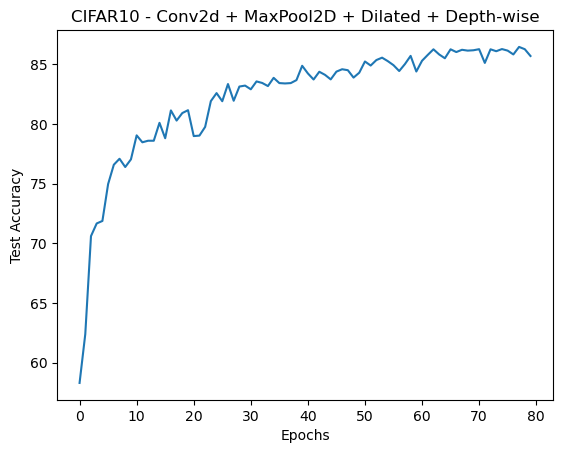

In [24]:
test_acc_list = deepcopy(test_acc)
plt.plot(list(range(80)), test_acc_list)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('CIFAR10 - Conv2d + MaxPool2D + Dilated + Depth-wise')

Text(0.5, 1.0, 'CIFAR10 - Conv2d + MaxPool2D + Dilated + Depth-wise')

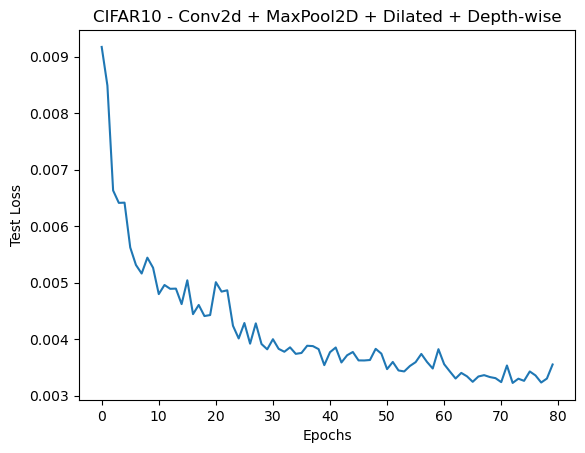

In [25]:
test_losses_list = deepcopy(list(map(lambda x: x.cpu().item(), test_losses)))
plt.plot(list(range(80)), test_losses_list)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('CIFAR10 - Conv2d + MaxPool2D + Dilated + Depth-wise')

In [26]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CIFAR10CNN3().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 28, 28]             640
            Conv2d-5           [-1, 64, 28, 28]           4,160
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]             640
            Conv2d-9           [-1, 64, 28, 28]           4,160
      BatchNorm2d-10           [-1, 64, 28, 28]             128
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]             640
           Conv2d-13           [-1, 64, 28, 28]           4,160
      BatchNorm2d-14           [-1

In [27]:
from torch.optim.lr_scheduler import StepLR, LambdaLR

model =  CIFAR10CNN3().to(device)
optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 80
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

EPOCH: 0


Loss=1.4252631664276123 Batch_id=390 Accuracy=39.99: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.75it/s]



Test set: Average loss: 0.0109, Accuracy: 5123/10000 (51.23%)

EPOCH: 1


Loss=1.1141241788864136 Batch_id=390 Accuracy=51.80: 100%|███████████████████████████| 391/391 [00:50<00:00,  7.67it/s]



Test set: Average loss: 0.0098, Accuracy: 5737/10000 (57.37%)

EPOCH: 2


Loss=1.2289142608642578 Batch_id=390 Accuracy=56.78: 100%|███████████████████████████| 391/391 [00:55<00:00,  6.99it/s]



Test set: Average loss: 0.0090, Accuracy: 5692/10000 (56.92%)

EPOCH: 3


Loss=1.0430245399475098 Batch_id=390 Accuracy=60.67: 100%|███████████████████████████| 391/391 [00:55<00:00,  7.10it/s]



Test set: Average loss: 0.0080, Accuracy: 6475/10000 (64.75%)

EPOCH: 4


Loss=1.085409164428711 Batch_id=390 Accuracy=63.12: 100%|████████████████████████████| 391/391 [00:58<00:00,  6.72it/s]



Test set: Average loss: 0.0066, Accuracy: 7129/10000 (71.29%)

EPOCH: 5


Loss=0.924176812171936 Batch_id=390 Accuracy=64.95: 100%|████████████████████████████| 391/391 [00:47<00:00,  8.20it/s]



Test set: Average loss: 0.0062, Accuracy: 7285/10000 (72.85%)

EPOCH: 6


Loss=0.8937884569168091 Batch_id=390 Accuracy=66.75: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 0.0064, Accuracy: 7105/10000 (71.05%)

EPOCH: 7


Loss=0.9587647318840027 Batch_id=390 Accuracy=67.89: 100%|███████████████████████████| 391/391 [00:35<00:00, 10.98it/s]



Test set: Average loss: 0.0057, Accuracy: 7485/10000 (74.85%)

EPOCH: 8


Loss=1.1034830808639526 Batch_id=390 Accuracy=68.74: 100%|███████████████████████████| 391/391 [00:36<00:00, 10.57it/s]



Test set: Average loss: 0.0062, Accuracy: 7279/10000 (72.79%)

EPOCH: 9


Loss=0.7694788575172424 Batch_id=390 Accuracy=69.56: 100%|███████████████████████████| 391/391 [00:56<00:00,  6.94it/s]



Test set: Average loss: 0.0060, Accuracy: 7497/10000 (74.97%)

EPOCH: 10


Loss=1.122238278388977 Batch_id=390 Accuracy=70.31: 100%|████████████████████████████| 391/391 [00:58<00:00,  6.68it/s]



Test set: Average loss: 0.0053, Accuracy: 7668/10000 (76.68%)

EPOCH: 11


Loss=0.7674494385719299 Batch_id=390 Accuracy=71.54: 100%|███████████████████████████| 391/391 [01:00<00:00,  6.52it/s]



Test set: Average loss: 0.0051, Accuracy: 7834/10000 (78.34%)

EPOCH: 12


Loss=0.6859621405601501 Batch_id=390 Accuracy=72.11: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.84it/s]



Test set: Average loss: 0.0050, Accuracy: 7821/10000 (78.21%)

EPOCH: 13


Loss=0.6648053526878357 Batch_id=390 Accuracy=72.46: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.78it/s]



Test set: Average loss: 0.0051, Accuracy: 7779/10000 (77.79%)

EPOCH: 14


Loss=0.8027079701423645 Batch_id=390 Accuracy=73.14: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.79it/s]



Test set: Average loss: 0.0047, Accuracy: 7980/10000 (79.80%)

EPOCH: 15


Loss=0.8291451334953308 Batch_id=390 Accuracy=73.35: 100%|███████████████████████████| 391/391 [00:58<00:00,  6.69it/s]



Test set: Average loss: 0.0051, Accuracy: 7867/10000 (78.67%)

EPOCH: 16


Loss=0.7739038467407227 Batch_id=390 Accuracy=73.98: 100%|███████████████████████████| 391/391 [00:58<00:00,  6.72it/s]



Test set: Average loss: 0.0048, Accuracy: 8021/10000 (80.21%)

EPOCH: 17


Loss=0.8412221670150757 Batch_id=390 Accuracy=74.54: 100%|███████████████████████████| 391/391 [00:58<00:00,  6.71it/s]



Test set: Average loss: 0.0049, Accuracy: 7933/10000 (79.33%)

EPOCH: 18


Loss=0.7355670928955078 Batch_id=390 Accuracy=74.73: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.77it/s]



Test set: Average loss: 0.0043, Accuracy: 8178/10000 (81.78%)

EPOCH: 19


Loss=0.8587309718132019 Batch_id=390 Accuracy=75.25: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.76it/s]



Test set: Average loss: 0.0046, Accuracy: 8005/10000 (80.05%)

EPOCH: 20


Loss=0.7620314359664917 Batch_id=390 Accuracy=75.71: 100%|███████████████████████████| 391/391 [00:58<00:00,  6.74it/s]



Test set: Average loss: 0.0048, Accuracy: 7909/10000 (79.09%)

EPOCH: 21


Loss=0.6685813665390015 Batch_id=390 Accuracy=75.82: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.76it/s]



Test set: Average loss: 0.0041, Accuracy: 8266/10000 (82.66%)

EPOCH: 22


Loss=0.5745278596878052 Batch_id=390 Accuracy=76.18: 100%|███████████████████████████| 391/391 [00:52<00:00,  7.43it/s]



Test set: Average loss: 0.0046, Accuracy: 8042/10000 (80.42%)

EPOCH: 23


Loss=0.6054759621620178 Batch_id=390 Accuracy=76.70: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.81it/s]



Test set: Average loss: 0.0044, Accuracy: 8125/10000 (81.25%)

EPOCH: 24


Loss=0.7366043925285339 Batch_id=390 Accuracy=76.78: 100%|███████████████████████████| 391/391 [00:35<00:00, 10.95it/s]



Test set: Average loss: 0.0050, Accuracy: 7991/10000 (79.91%)

EPOCH: 25


Loss=0.690959095954895 Batch_id=390 Accuracy=77.03: 100%|████████████████████████████| 391/391 [00:36<00:00, 10.80it/s]



Test set: Average loss: 0.0044, Accuracy: 8131/10000 (81.31%)

EPOCH: 26


Loss=0.642928957939148 Batch_id=390 Accuracy=77.05: 100%|████████████████████████████| 391/391 [00:35<00:00, 10.91it/s]



Test set: Average loss: 0.0038, Accuracy: 8361/10000 (83.61%)

EPOCH: 27


Loss=0.6358882188796997 Batch_id=390 Accuracy=77.35: 100%|███████████████████████████| 391/391 [00:35<00:00, 10.93it/s]



Test set: Average loss: 0.0042, Accuracy: 8195/10000 (81.95%)

EPOCH: 28


Loss=0.560936689376831 Batch_id=390 Accuracy=77.78: 100%|████████████████████████████| 391/391 [00:36<00:00, 10.72it/s]



Test set: Average loss: 0.0038, Accuracy: 8345/10000 (83.45%)

EPOCH: 29


Loss=0.6126305460929871 Batch_id=390 Accuracy=78.30: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.79it/s]



Test set: Average loss: 0.0047, Accuracy: 8035/10000 (80.35%)

EPOCH: 30


Loss=0.614610493183136 Batch_id=390 Accuracy=78.17: 100%|████████████████████████████| 391/391 [00:56<00:00,  6.96it/s]



Test set: Average loss: 0.0038, Accuracy: 8359/10000 (83.59%)

EPOCH: 31


Loss=0.5574778914451599 Batch_id=390 Accuracy=78.36: 100%|███████████████████████████| 391/391 [00:51<00:00,  7.55it/s]



Test set: Average loss: 0.0042, Accuracy: 8196/10000 (81.96%)

EPOCH: 32


Loss=0.5483974814414978 Batch_id=390 Accuracy=78.49: 100%|███████████████████████████| 391/391 [00:56<00:00,  6.87it/s]



Test set: Average loss: 0.0038, Accuracy: 8344/10000 (83.44%)

EPOCH: 33


Loss=0.5278891921043396 Batch_id=390 Accuracy=78.77: 100%|███████████████████████████| 391/391 [00:56<00:00,  6.89it/s]



Test set: Average loss: 0.0038, Accuracy: 8334/10000 (83.34%)

EPOCH: 34


Loss=0.7205222249031067 Batch_id=390 Accuracy=78.98: 100%|███████████████████████████| 391/391 [00:56<00:00,  6.89it/s]



Test set: Average loss: 0.0039, Accuracy: 8367/10000 (83.67%)

EPOCH: 35


Loss=0.7502605319023132 Batch_id=390 Accuracy=78.89: 100%|███████████████████████████| 391/391 [00:55<00:00,  7.04it/s]



Test set: Average loss: 0.0041, Accuracy: 8261/10000 (82.61%)

EPOCH: 36


Loss=0.6151791214942932 Batch_id=390 Accuracy=79.24: 100%|███████████████████████████| 391/391 [00:54<00:00,  7.13it/s]



Test set: Average loss: 0.0044, Accuracy: 8120/10000 (81.20%)

EPOCH: 37


Loss=0.6096492409706116 Batch_id=390 Accuracy=79.71: 100%|███████████████████████████| 391/391 [00:49<00:00,  7.92it/s]



Test set: Average loss: 0.0043, Accuracy: 8155/10000 (81.55%)

EPOCH: 38


Loss=0.8221721649169922 Batch_id=390 Accuracy=79.52: 100%|███████████████████████████| 391/391 [00:54<00:00,  7.12it/s]



Test set: Average loss: 0.0041, Accuracy: 8281/10000 (82.81%)

EPOCH: 39


Loss=0.6620897650718689 Batch_id=390 Accuracy=79.65: 100%|███████████████████████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Average loss: 0.0035, Accuracy: 8455/10000 (84.55%)

EPOCH: 40


Loss=0.6114363074302673 Batch_id=390 Accuracy=79.94: 100%|███████████████████████████| 391/391 [00:37<00:00, 10.52it/s]



Test set: Average loss: 0.0039, Accuracy: 8373/10000 (83.73%)

EPOCH: 41


Loss=0.36900830268859863 Batch_id=390 Accuracy=80.04: 100%|██████████████████████████| 391/391 [00:36<00:00, 10.69it/s]



Test set: Average loss: 0.0035, Accuracy: 8534/10000 (85.34%)

EPOCH: 42


Loss=0.6626940369606018 Batch_id=390 Accuracy=80.10: 100%|███████████████████████████| 391/391 [00:36<00:00, 10.78it/s]



Test set: Average loss: 0.0038, Accuracy: 8429/10000 (84.29%)

EPOCH: 43


Loss=0.5308014750480652 Batch_id=390 Accuracy=80.36: 100%|███████████████████████████| 391/391 [00:36<00:00, 10.85it/s]



Test set: Average loss: 0.0035, Accuracy: 8505/10000 (85.05%)

EPOCH: 44


Loss=0.5556600093841553 Batch_id=390 Accuracy=80.53: 100%|███████████████████████████| 391/391 [00:35<00:00, 10.87it/s]



Test set: Average loss: 0.0036, Accuracy: 8454/10000 (84.54%)

EPOCH: 45


Loss=0.35302039980888367 Batch_id=390 Accuracy=80.34: 100%|██████████████████████████| 391/391 [00:53<00:00,  7.29it/s]



Test set: Average loss: 0.0036, Accuracy: 8482/10000 (84.82%)

EPOCH: 46


Loss=0.642387330532074 Batch_id=390 Accuracy=80.36: 100%|████████████████████████████| 391/391 [00:52<00:00,  7.48it/s]



Test set: Average loss: 0.0040, Accuracy: 8370/10000 (83.70%)

EPOCH: 47


Loss=0.5595123171806335 Batch_id=390 Accuracy=80.70: 100%|███████████████████████████| 391/391 [00:41<00:00,  9.51it/s]



Test set: Average loss: 0.0034, Accuracy: 8544/10000 (85.44%)

EPOCH: 48


Loss=0.5706175565719604 Batch_id=390 Accuracy=81.22: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.46it/s]



Test set: Average loss: 0.0033, Accuracy: 8636/10000 (86.36%)

EPOCH: 49


Loss=0.6337280869483948 Batch_id=390 Accuracy=81.10: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.36it/s]



Test set: Average loss: 0.0036, Accuracy: 8530/10000 (85.30%)

EPOCH: 50


Loss=0.6206981539726257 Batch_id=390 Accuracy=81.19: 100%|███████████████████████████| 391/391 [00:35<00:00, 11.10it/s]



Test set: Average loss: 0.0032, Accuracy: 8667/10000 (86.67%)

EPOCH: 51


Loss=0.48786813020706177 Batch_id=390 Accuracy=81.13: 100%|██████████████████████████| 391/391 [00:57<00:00,  6.80it/s]



Test set: Average loss: 0.0032, Accuracy: 8619/10000 (86.19%)

EPOCH: 52


Loss=0.4997592866420746 Batch_id=390 Accuracy=81.38: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.46it/s]



Test set: Average loss: 0.0041, Accuracy: 8371/10000 (83.71%)

EPOCH: 53


Loss=0.406826913356781 Batch_id=390 Accuracy=81.39: 100%|████████████████████████████| 391/391 [00:34<00:00, 11.45it/s]



Test set: Average loss: 0.0035, Accuracy: 8563/10000 (85.63%)

EPOCH: 54


Loss=0.6098593473434448 Batch_id=390 Accuracy=81.57: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.38it/s]



Test set: Average loss: 0.0035, Accuracy: 8462/10000 (84.62%)

EPOCH: 55


Loss=0.4608968198299408 Batch_id=390 Accuracy=81.35: 100%|███████████████████████████| 391/391 [00:39<00:00,  9.87it/s]



Test set: Average loss: 0.0035, Accuracy: 8534/10000 (85.34%)

EPOCH: 56


Loss=0.3980562388896942 Batch_id=390 Accuracy=81.71: 100%|███████████████████████████| 391/391 [00:44<00:00,  8.88it/s]



Test set: Average loss: 0.0032, Accuracy: 8672/10000 (86.72%)

EPOCH: 57


Loss=0.4508042335510254 Batch_id=390 Accuracy=81.94: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.45it/s]



Test set: Average loss: 0.0035, Accuracy: 8538/10000 (85.38%)

EPOCH: 58


Loss=0.30216243863105774 Batch_id=390 Accuracy=81.81: 100%|██████████████████████████| 391/391 [00:34<00:00, 11.38it/s]



Test set: Average loss: 0.0034, Accuracy: 8584/10000 (85.84%)

EPOCH: 59


Loss=0.4992137551307678 Batch_id=390 Accuracy=82.01: 100%|███████████████████████████| 391/391 [00:35<00:00, 10.86it/s]



Test set: Average loss: 0.0037, Accuracy: 8471/10000 (84.71%)

EPOCH: 60


Loss=0.649333119392395 Batch_id=390 Accuracy=81.92: 100%|████████████████████████████| 391/391 [00:35<00:00, 11.06it/s]



Test set: Average loss: 0.0033, Accuracy: 8652/10000 (86.52%)

EPOCH: 61


Loss=0.5146543979644775 Batch_id=390 Accuracy=81.99: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.44it/s]



Test set: Average loss: 0.0032, Accuracy: 8704/10000 (87.04%)

EPOCH: 62


Loss=0.4439830183982849 Batch_id=390 Accuracy=82.43: 100%|███████████████████████████| 391/391 [00:35<00:00, 10.90it/s]



Test set: Average loss: 0.0033, Accuracy: 8614/10000 (86.14%)

EPOCH: 63


Loss=0.5858595371246338 Batch_id=390 Accuracy=82.51: 100%|███████████████████████████| 391/391 [00:37<00:00, 10.55it/s]



Test set: Average loss: 0.0033, Accuracy: 8647/10000 (86.47%)

EPOCH: 64


Loss=0.5996848940849304 Batch_id=390 Accuracy=82.53: 100%|███████████████████████████| 391/391 [00:56<00:00,  6.93it/s]



Test set: Average loss: 0.0032, Accuracy: 8599/10000 (85.99%)

EPOCH: 65


Loss=0.5711208581924438 Batch_id=390 Accuracy=82.26: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.86it/s]



Test set: Average loss: 0.0031, Accuracy: 8664/10000 (86.64%)

EPOCH: 66


Loss=0.47842201590538025 Batch_id=390 Accuracy=82.49: 100%|██████████████████████████| 391/391 [00:57<00:00,  6.77it/s]



Test set: Average loss: 0.0033, Accuracy: 8659/10000 (86.59%)

EPOCH: 67


Loss=0.5967152714729309 Batch_id=390 Accuracy=82.91: 100%|███████████████████████████| 391/391 [00:43<00:00,  8.90it/s]



Test set: Average loss: 0.0032, Accuracy: 8684/10000 (86.84%)

EPOCH: 68


Loss=0.5651540756225586 Batch_id=390 Accuracy=83.00: 100%|███████████████████████████| 391/391 [00:36<00:00, 10.84it/s]



Test set: Average loss: 0.0034, Accuracy: 8618/10000 (86.18%)

EPOCH: 69


Loss=0.4185717701911926 Batch_id=390 Accuracy=83.14: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.81it/s]



Test set: Average loss: 0.0031, Accuracy: 8727/10000 (87.27%)

EPOCH: 70


Loss=0.32633715867996216 Batch_id=390 Accuracy=83.00: 100%|██████████████████████████| 391/391 [00:54<00:00,  7.19it/s]



Test set: Average loss: 0.0031, Accuracy: 8687/10000 (86.87%)

EPOCH: 71


Loss=0.5173192620277405 Batch_id=390 Accuracy=82.93: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.82it/s]



Test set: Average loss: 0.0036, Accuracy: 8567/10000 (85.67%)

EPOCH: 72


Loss=0.5689528584480286 Batch_id=390 Accuracy=83.25: 100%|███████████████████████████| 391/391 [00:56<00:00,  6.93it/s]



Test set: Average loss: 0.0030, Accuracy: 8724/10000 (87.24%)

EPOCH: 73


Loss=0.4853082597255707 Batch_id=390 Accuracy=83.07: 100%|███████████████████████████| 391/391 [00:58<00:00,  6.74it/s]



Test set: Average loss: 0.0035, Accuracy: 8556/10000 (85.56%)

EPOCH: 74


Loss=0.47918519377708435 Batch_id=390 Accuracy=83.62: 100%|██████████████████████████| 391/391 [00:53<00:00,  7.30it/s]



Test set: Average loss: 0.0035, Accuracy: 8544/10000 (85.44%)

EPOCH: 75


Loss=0.47113198041915894 Batch_id=390 Accuracy=83.40: 100%|██████████████████████████| 391/391 [00:55<00:00,  7.03it/s]



Test set: Average loss: 0.0032, Accuracy: 8695/10000 (86.95%)

EPOCH: 76


Loss=0.6033066511154175 Batch_id=390 Accuracy=83.04: 100%|███████████████████████████| 391/391 [00:51<00:00,  7.59it/s]



Test set: Average loss: 0.0029, Accuracy: 8818/10000 (88.18%)

EPOCH: 77


Loss=0.48077163100242615 Batch_id=390 Accuracy=83.54: 100%|██████████████████████████| 391/391 [00:57<00:00,  6.81it/s]



Test set: Average loss: 0.0032, Accuracy: 8631/10000 (86.31%)

EPOCH: 78


Loss=0.39817890524864197 Batch_id=390 Accuracy=83.58: 100%|██████████████████████████| 391/391 [00:56<00:00,  6.88it/s]



Test set: Average loss: 0.0034, Accuracy: 8644/10000 (86.44%)

EPOCH: 79


Loss=0.5710405111312866 Batch_id=390 Accuracy=83.69: 100%|███████████████████████████| 391/391 [00:57<00:00,  6.81it/s]



Test set: Average loss: 0.0031, Accuracy: 8779/10000 (87.79%)



In [35]:
len(test_acc), len(test_acc_list)

(160, 80)

Text(0.5, 1.0, 'CIFAR10 - Conv2d + Dilated(instead of MaxPool2d) + Depth-wise')

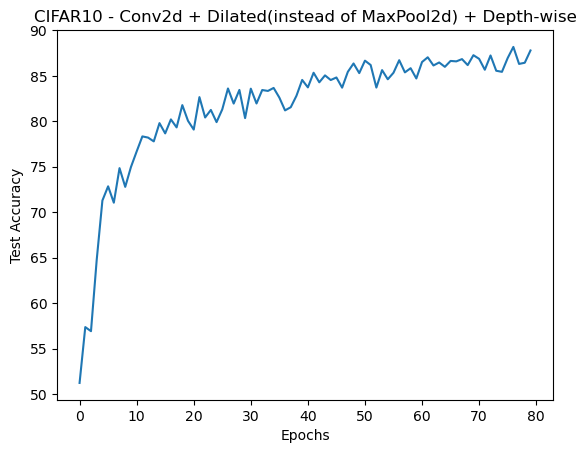

In [41]:
test_acc_list2 = deepcopy(test_acc[80:])
plt.plot(list(range(80)), test_acc_list2)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('CIFAR10 - Conv2d + Dilated(instead of MaxPool2d) + Depth-wise')

Text(0.5, 1.0, 'CIFAR10 - Conv2d + Dilated(instead of MaxPool2d) + Depth-wise')

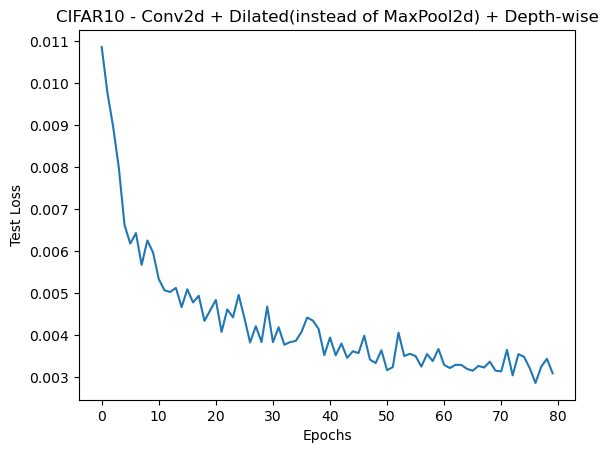

In [42]:
test_loss_list2 = list(map(lambda x: x.cpu().item(), test_losses[80:]))
plt.plot(list(range(80)), test_loss_list2)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title("CIFAR10 - Conv2d + Dilated(instead of MaxPool2d) + Depth-wise")